# Quantum Algorithms for Portfolio Optimization 

Beom Joon Baek - September 23rd, 2021

# 0. Today's Topics

1. Formulating Portfolio Optimization Problem
2. Quadratic Unconstrained Binary Optimization (**QUBO**)
3. Quantum Approximate Optimization Algorithm (**QAOA**)
4. Qiskit Implementation of Portfolio Optimization Problem
5. Results & Conclusions

# 1. Converting Portfolio Optimzation to QUBO to an Ising Model


Mean-variance portfolio optimization problem is a type of optimization problem where given the $n$ universe of possible investments, you choose a number of investments such that you will maximize the following function with corresponding risk appetite, returns, and budget:

$$
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } P^T x \leq B
$$

where we use the following notation:
* $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$)
* $\mu \in \mathbb{R}^n$ defines the expected returns for the assets
* $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets
* $q > 0$ controls the risk appetite of the decision maker
* $B$ denotes the budget, i.e. the available money to spend on assets
* $P \in \mathbb{R}^n$ represents the price associated with each assets

Thus this formulation of portfolio optimization problem has **binary** variables, **linear** & **quadratic** terms, and **linear constraints** with **inequalities**.

# 2. Quadratic Unconstrained Binary Optimization (QUBO)

QUBO can help us frame the portfolio optimization problem as a particular optimization problem.

## What is QUBO?
**Quadratic Unconstrained Binary Optimization (QUBO)** is an NP-hard optimization problem. Let's parse through QUBO's acronym. 

* **Quadratic**: terms involved in the equation are up to second order
* **Unconstrained**: no conditions on the variable to be optimized (although there can be workarounds on this)
* **Binary**: variable to be optimized is a binary vector consisting of 0 and 1

QUBO can be mathematically formalized as follows:
$$\text{Min} \, y = x^T \, Q\, x \\
\text{s.t.}  \; x \in S$$

where
* $S$ is a binary discrete set $\{0, 1\}^n$ (or $\{-1, 1\}^n$ depending on the problem)
* $Q$ is an N x N symmetric matrix
* $y$ is the function to be optimized, called *objective function*

When we have an objective function to maximize, we just multiply the function with -1

## **Q1**:  How do we add constraints?
Technically, QUBO does not have constraints on $x$. Fortunately, we can add **penalties**. By adding penalty terms onto the objetive function, it incentives the solver to take into consideration the constraint terms. Thus, this is one part why QUBO is so generalizable.  

<img src="Visuals/table1-penalty.PNG">

This is a set of common penalties in QUBO problem. 

### Example

Classical constraint of $x + y \leq 1$ means that $x$ and $y$ both cannot be selected.

$$ \text{Min} \, y = f(x) + P \: x y $$

Considering that both are binary variables, a penalty term of $ P xy$ has a positive value when the constraint is not met while 0 when it is met. When the quadratic solver minimizes BOTH the objective function $f(x)$ and the penalty term $ P xy$, it will be incentivized to find $x$ that adheres to the constraint.

It is more art than science to choose the penalty weight $P$. Depending on the problem, there could be multitude of constraints and we could formulate a QUBO where one constraint has higher weight (and thus higher likelihood that specific constraint would be met than other constraints). 
* Too big of a $P$ makes the objective function irrelevant.
* Too small of a $P$ makes the penalty irrelevant.

*Rule of thumb*: 75% to 150% of the objective function (sum of its coefficients). 

### Generalization of Constraints

We can generalize the above constraints to any case of linear constraints. Given a linear constraint $Ax = b$, we an add a quadratic penalty $P(Ax-b)^T(Ax-b)$ to the objective function.

$$ y = x^T C x + P (Ax - b)^T (Ax - b) \\
 = x^T C x + x^T D x + c \\
 = x^T Q x + c  $$

Note that $D$ and $c$ are resulting matrix and vector from the matrix multiplication. For purposes of minimization, constant $c$ can be dropped. With this, QUBO can encompass linear constraints.

## **Q2**: How do we handle inequalities? 
We introduce **slack variables**. Slack variables fill the gap between the objective function and its upper or lower bounds.

For example, suppose that we have a minimization problem as follows:

$$\text{Min} \, y = 2x_1 + x_2 + x_3 \\
\text{s.t.} \; x_1 + x_2 + x_3 \leq 5$$

We introduce slack variable $s$. 

$$
\text{Min} \, y = 2x_1 + x_2 + x_3 \\
\text{s.t.} \; x_1 + x_2 + x_3 + s = 5
$$

We can calculate the upper bounds of the slack variable by figuring out the LHS's minimum. In this case, when $x_1$, $x_2$, and $x_3$ are 0, $s$ should be at max 5 to satisfy the constraint. 

Now, $s$ is an integer variable, which we need to convert to a binary variable. We use binary expansion where:

$$\text{min} \, y = 2x_1 + x_2 + x_3 \\
\text{s.t.} \; x_1 + x_2 + x_3 + 1 s_0 + 2 s_1 + 2 s_2 = 5$$

With these set of transformations, we can formulate any quadratic objetive function with linear constraint into QUBO form. 

## Q3. How do we handle linear terms?
Binary variables satisfy this property: $x_1$ = $x_1^2$. Basically all linear terms represented in the diagonal elements of $Q$ in $x^T Q x$ equation.

Things to note

(1) Think of this conversation between $x_i$ to $\sigma_i$ as follows:
<img src="Visuals/figure2-sigma.PNG">
This is due to the fact that while $x_i \in \{0, 1\}$, $\sigma_i \in \{-1, 1\}$. We have to change the sign of $Z_i$ to align the eigenvalue of 1 to state $|1\rangle$. 

(2) The coefficients in the linear terms of the objevtive function are embedded in vector $h$ while the quadratic terms are embedded in matrix $J$. 

# 3. Quantum Approximate Optimization Algorithm (QAOA)
While QUBO has a set of classical solvers (genetic algorithms, ML-based methods, simulated annealing, etc), QUBO could also be formulated as an **Ising Model** to be solved in Quantum Computers. Note that there is **NO** theoretical guarantee that Quantum Computers can accelereate the QUBO problem so this is an active area of research.

<img src="Visuals/Ising.PNG">

## QUBO to Ising Model

Converting QUBO to Ising Model is relatively straightforward.

If given QUBO problem:
$$f(x) = x^T \, Q\, x$$
$$= \sum_{i , j} J_{ij}x_ix_j$$
$$= \sum_{i}^N h_ix_i + \sum_{i < j} J_{ij}x_ix_j$$

we can express this as a corresponding Hamiltonian:

$$ H(x_1, x_2,\dots, x_n) = -\sum_{i}^N h_i\sigma^z_i - \sum_{i < j} J_{ij}\sigma^z_i\sigma^z_j,$$

where $\sigma_i$ is $\left(\frac{I - Z_i}{2}\right)$. 

(1) Think of this conversation between $x_i$ to $\sigma_i$ as follows:
<img src="Visuals/figure2-sigma.PNG">
This is due to the fact that while $x_i \in \{0, 1\}$, $\sigma_i \in \{-1, 1\}$. We have to change the sign of $Z_i$ to align the eigenvalue of 1 to state $|1\rangle$. 

(2) The coefficients in the linear terms of the objevtive function are embedded in vector $h$ while the quadratic terms are embedded in matrix $J$. 

## Recap on Quantum Mechanics: Time Evolution
In quantum mechanics, time evolution is given by the Schrodinger equation:

$$ i \hbar \frac{\partial }{\partial t} |\psi(x,t) \rangle = \hat{H} | \psi (x,t) \rangle $$

The change of the state of quantum system is dictated by the Hamiltonian. It is a linear operator that shows how the system changees through time. Solving this differential equation gives us:

$$ |\psi(x,t) \rangle = e^{-i \hat{H} t} | \psi (x,t) \rangle $$

So far, we have embedded our problem as a Hamiltonian. Let's represent that Hamiltonian as $H_c$ with c meaning "cost". If we have a Hamiltonian, we can express a corresponding unitary operator $U(H_c, \gamma) = e^{-i \gamma H_c}$

## Recap on Quantum Mechanics: Trotterization
Basically discretization of continuous time evolution of the Hamiltonian.

<img src="Visuals/trot.PNG">

## Adiabatic Quantum Computation
<img src="Visuals/AQC.PNG">

Basic idea: Start in a simple state with Hamiltonian $H_s$. Then **slowly** evolve the system so that it reaches our intended state $H_c$.

**Caveat**: Adiabatic Quantum Computation requires a LOT of quantum operations. It is very difficult to implement this on our current devices.

## Solution: Quantum Approximate Optimization Algorithm

QAOA is a quantum algorithm to solve optimization problems. Think of it as an approximation of Adiabatic Quantum Computation. It's as if we use two unitary operations: $U(H_c, \gamma)$ and $U(H_b, \beta)$ to trotterize AQC. We approximate the optimal state by applying both uniary operators $p$ times from the initial state $|\psi_0\rangle$. At first, parameters $\gamma$ and $\beta$ are random. But we use classical optimizer to finetune these parameters as we lower the measured value.

$$|\psi_{opt}\rangle = U(H_c, \gamma) U(H_b, \beta) \dots U(H_c, \gamma) U(H_b, \beta) |\psi_0\rangle $$

<img src="Visuals/QAOA.PNG">


# 4. Qiskit Implementation of Portfolio Optimization Problem

Qiskit has both **Optimization** module and **Finance** module. While the finance module has an in-built portfolio optimization object that takes in risk factor, budget, expected returns and covariance as inputs and returns the optimized values, it does NOT allow (1) different assets prices and (2) inequality constraints. 

Thus, I used the Optimization module to create the extended Portfolio Optimization code that accounts for two cases. Fortunately, the Optimization module offers methods for various transformations needed for this problem. 

The steps taken are:
1. Import data to calculate mean & covariance
2. Create QUBO problem
  1. Formulate a quadratic problem with its objective function ($q$, $\mu$ and $\Sigma$)
  2. Add linear inequality constraints to QP ($P$ and $B$)
  3. Convert inequality constraint into equality constraint with slack variables
  4. Convert slack variables into binary variables
  5. Convert constraint into a penalty term in objective function (QUBO form)
3. Convert QUBO to Ising Model & Hamiltonian
4. Perform four methods to solve the optimization problem:
    1. Classical Solver
    2. VQE
    3. QAOA
    4. CVaR (extended version of VQE)
5. Compare results for each algorithm for different problem input. We change following values:
  1. risk factor q
  2. budget B
  3. number of assets N

## 0. Install and Import Packages
Make sure all code are imported!

In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_optimization

In [ ]:
!pip install qiskit_finance

In [ ]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, InequalityToEquality, IntegerToBinary
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import execute, Aer
from qiskit.utils import algorithm_globals
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import SPSA
from qiskit import IBMQ
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime

## 1. Import data to calculate mean & covariance

We can either use real stock data or generate artificial data.

In [ ]:
## Import Stock Data
stocks = ["AAPL", "UAL", "TSLA", "AMD", "IBM", "ATVI", "ADBE", "AMZN"]

def get_real_data(n, visual=True):
    stocks_n = stocks[:n]
    try:
        wiki = YahooDataProvider(
                         tickers = stocks_n,
                         start = datetime.datetime(2020,3,1),
                         end = datetime.datetime(2020,4,1))
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")
    
    if wiki._data and visual:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks_n):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    if wiki._n > 1 and visual:
        cov = wiki.get_covariance_matrix()
        print("A covariance matrix:")
        print(cov)
        plt.imshow(cov)
        plt.show()

    mu = wiki.get_mean_vector()
    sigma = wiki.get_covariance_matrix()
    
    return mu, sigma

In [ ]:
def get_fake_data(n, visual):
        sigma = np.random.uniform(-3,3,[n,n])
        mu = np.random.sample(n) * 5 + 1
        if visual:
            print(sigma)
            plt.imshow(sigma)
            plt.show()
        return mu, sigma

We can see the results of real stock price and its corresponding covariance matrix.

The underlying evolution of stock prices:


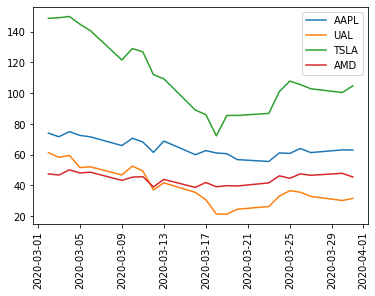

A covariance matrix:
[[ 31.9925663   64.89204076 122.59788804  14.01789432]
 [ 64.89204076 156.0590341  287.40000396  28.77659694]
 [122.59788804 287.40000396 568.75331423  61.88289175]
 [ 14.01789432  28.77659694  61.88289175  12.43027577]]


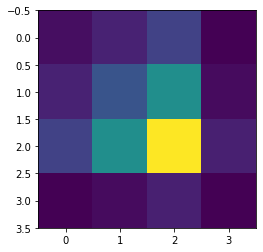

(array([ 64.99594706,  39.51636358, 111.82027297,  44.42409117]),
 array([[ 31.9925663 ,  64.89204076, 122.59788804,  14.01789432],
        [ 64.89204076, 156.0590341 , 287.40000396,  28.77659694],
        [122.59788804, 287.40000396, 568.75331423,  61.88289175],
        [ 14.01789432,  28.77659694,  61.88289175,  12.43027577]]))

In [ ]:
get_real_data(n=4, visual=True)

Or we can generate fake one. It does not matter.

[[ 0.93156609  2.22705539  2.29598478 -1.06842878]
 [-0.25331948 -2.19315401 -0.5430922  -0.74236498]
 [-2.40628773  2.01571374 -2.58599029  0.54585979]
 [ 0.35807234 -0.76523101 -1.95772639  1.28958052]]


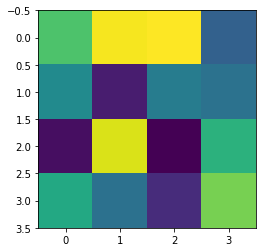

(array([5.81753927, 5.75791413, 3.61205287, 5.75233648]),
 array([[ 0.93156609,  2.22705539,  2.29598478, -1.06842878],
        [-0.25331948, -2.19315401, -0.5430922 , -0.74236498],
        [-2.40628773,  2.01571374, -2.58599029,  0.54585979],
        [ 0.35807234, -0.76523101, -1.95772639,  1.28958052]]))

In [ ]:
get_fake_data(4, True)

## 2. Create QUBO Problem

Qiskit Optimization provides native ways to formulate a QUBO problem. We will follow the steps above exactly.

In [ ]:
def create_prices(n):
  prices = [np.random.randint(1, 6) for _ in range(n)]
  return prices

def create_qubo(q, n, dB, stocks, mu, sigma, prices, verbose=False):
  price_dict = {stock:price for stock, price in zip(stocks, prices)} 
  budget = int(sum(prices) / 2) + dB

  # make QP
  mod = QuadraticProgram('portfolio-optimization')
  for stock in stocks:
    mod.binary_var(stock)
  mod.minimize(linear=-mu, quadratic=q*sigma)
  mod.linear_constraint(linear=price_dict, sense='<=', rhs=budget, name='budget')

  # make QUBO
  ineq2eq = InequalityToEquality()
  mod1 = ineq2eq.convert(mod)

  int2bin = IntegerToBinary()
  mod2 = int2bin.convert(mod1)

  lineq2penalty = LinearEqualityToPenalty()
  qubo = lineq2penalty.convert(mod2)

  if verbose:
    print("QUBO Problem statement")
    print(qubo)
  
  return qubo

Now let's try to see if this works.

In [ ]:
q = 1
n = 4
dB = 0
stocks_n = stocks[:n]

mu, sigma = get_fake_data(n, False)
prices = create_prices(n)

qubo = create_qubo(q, n, dB, stocks, mu, sigma, prices, True)

QUBO Problem statement
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio-optimization

Minimize
 obj: - 524.127737833066 AAPL - 350.558401140119 UAL - 175.182806808842 TSLA
      - 524.384042560210 AMD - 174.035458018464 budget@int_slack@0
      - 348.070916036927 budget@int_slack@1
      - 174.035458018464 budget@int_slack@2 + [ 391.836266846014 AAPL^2
      + 520.185756293370 AAPL*UAL + 268.432729525701 AAPL*TSLA
      + 777.998489953516 AAPL*AMD + 261.053187027696 AAPL*budget@int_slack@0
      + 522.106374055391 AAPL*budget@int_slack@1
      + 261.053187027696 AAPL*budget@int_slack@2 + 176.036938956814 UAL^2
      + 174.430753694364 UAL*TSLA + 520.514194281148 UAL*AMD
      + 174.035458018464 UAL*budget@int_slack@0
      + 348.070916036927 UAL*budget@int_slack@1
      + 174.035458018464 UAL*budget@int_slack@2 + 40.838735996615 TSLA^2
      + 262.101198503554 TSLA*AMD + 87.017729009232 TSLA*budget@int_slack@0
      + 174.035458018464 TSLA*budget

Note how all the variables are binary, how there is no constraint, and there are slack variables. The reason why we randomly generated smaller integer budgets and prices is because having a large budget meant more extraneous slack variables. While not a huge concern if we use classical optimizer, if using quantum optimization methods we would use precious qubits and that is a waste of resources.

## 3. Convert QUBO to Ising Model
Same as above, Qiskit Optimization provides native method to do that.

In [ ]:
ising, offset = qubo.to_ising()

## 4. Perform four methods to solve the optimization problem
  1. Classical Solver
  2. VQE
  3. QAOA
  4. CVaR (extended version of VQE)

In [ ]:
algorithms = ["exact", "vqe", "qaoa", "cvar"]
def run_trial(qubo, ising):
  results = {algo: 0 for algo in algorithms}

  # exact
  exact_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qubo)
  results["exact"] = exact_result

  # VQE
  maxiter = 100
  counts = 1024
  optimizer = COBYLA(maxiter=maxiter)
  backend_name = 'qasm_simulator'
  backend=Aer.get_backend(backend_name)
  ry = TwoLocal(ising.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
  vqe_mes = VQE(ansatz=ry, optimizer=optimizer, quantum_instance=backend)
  vqe_result = MinimumEigenOptimizer(vqe_mes).solve(qubo)
  results["vqe"]=(vqe_result)  

  # qaoa
  qaoa_mes = QAOA(quantum_instance = backend, initial_point=[0., 0.])
  qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
  qaoa_result = qaoa.solve(qubo)
  results["qaoa"]=qaoa_result

  # cvar
  alpha = 0.25
  cvar_exp = CVaRExpectation(alpha, PauliExpectation())
  cvar_exp.compute_variance = lambda x: [0]
  ansatz = RealAmplitudes(n, reps=1)
  cvar_mes = VQE(expectation=cvar_exp, optimizer=optimizer, ansatz=ansatz, quantum_instance=backend)  
  cvar = MinimumEigenOptimizer(cvar_mes)
  cvar_result = cvar.solve(qubo)
  results["cvar"] = cvar_result

  return results

Let's give this a try!

In [ ]:
run_trial(qubo, ising)

{'cvar': optimal function value: -3.885827547852614
 optimal value: [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 status: SUCCESS, 'exact': optimal function value: -5.8442348543016465
 optimal value: [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 status: SUCCESS, 'qaoa': optimal function value: -5.8442348543016465
 optimal value: [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 status: SUCCESS, 'vqe': optimal function value: -5.8442348543016465
 optimal value: [0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 status: SUCCESS}

Seems like for n=4 case, all three quantum algorithms adhere to the classical result. I will assume that the classical result is the global minimum.

## 5. Compare results for each algorithm for different problem input

We vary the input to see which algorithm would respond to which situations.

## (a) Changing Budget
Before, we calculated the budget as being the mean of all the prices. Now, we have this variable dB that can modulate from the mean.

In [ ]:
labels = ["exact", "vqe", "qaoa", "cvar"]

q = 1
n = 5
dB = 0

stocks_n = stocks[:n]

In [ ]:
mu, sigma = get_fake_data(n, False)
prices = create_prices(n)

In [ ]:
dB_list = [-2, -1, 0, 1, 2]

data = {label: [] for label in labels}
for index, dB in enumerate(dB_list):
  qubo = create_qubo(q, n, dB, stocks, mu, sigma, prices, False)
  ising, offset = qubo.to_ising()
  results = run_trial(qubo, ising)
  for label, result in results.items():
    data[label].append(result.fval)

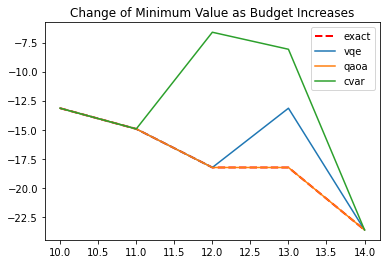

In [ ]:
plt.title("Change of Minimum Value as Budget Increases")
budget = [b + sum(prices) for b in dB_list]
for label in labels:
  if label == "exact":
    plt.plot(budget, data[label], 'r--', linewidth=2, label=label)
  else:
    plt.plot(budget, data[label], label=label)
plt.legend()
plt.show()

## (b) Changing Risk Factor
We change the risk factor q. 

In [ ]:
q_list = np.linspace(0.1, 1.9, num=10)
data_q = {label: [] for label in labels}

for index, q in enumerate(q_list):
  qubo = create_qubo(q, n, dB, stocks, mu, sigma, prices, False)
  ising, offset = qubo.to_ising()
  results_q = run_trial(qubo, ising)
  for label, result in results_q.items():
        data_q[label].append(result.fval)

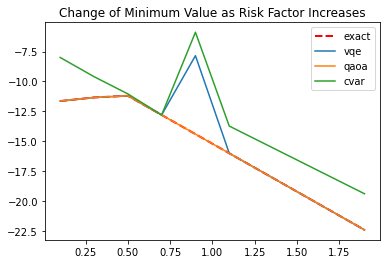

In [ ]:
plt.title("Change of Minimum Value as Risk Factor Increases")

for label in labels:
  if label == "exact":
    plt.plot(q_list, data_q[label], 'r--', linewidth=2, label=label)
  else:
    plt.plot(q_list, data_q[label], label=label)
plt.legend()
plt.show()

## (c) Changing Number of Assets

In [ ]:
n_list = [4, 5, 6, 7, 8]
data_n = {label: [] for label in labels}
for index, n in enumerate(n_list):
  qubo = create_qubo(q, n, dB, stocks, mu, sigma, prices, False)
  ising, offset = qubo.to_ising()
  results_n = run_trial(qubo, ising)
  for label, result in results_n.items():
        data_n[label].append(result.fval)

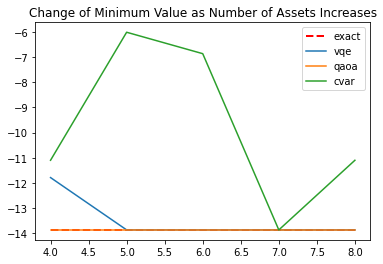

In [ ]:
plt.title("Change of Minimum Value as Number of Assets Increases")

for label in labels:
  if label == "exact":
    plt.plot(n_list, data_n[label], 'r--', linewidth=2, label=label)
  else:
    plt.plot(n_list, data_n[label], label=label)
plt.legend()
plt.show()

# 6. Conclusion

*   More of PoC rather than applicable in real-use.

*   There is **NO** theoretical justification that quantum computers are faster than classical computers when it comes to optimization problems, unlike other problems like prime factorization. 


*   Currently, quantum computers lack both the scale and the accuracy compared to classical computers, especially in the field of QUBO.


*   QAOA is a hybrid quantum algorithm in that it uses a classical optimizer. 








